# **Import Libraries**

In [1]:
# In a new Colab cell
# --- Step 1: Define the Problem & Import Libraries ---

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

# Models
import lightgbm as lgb

# Metrics & Evaluation
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    log_loss,
    precision_recall_curve
)

# Set some visualization styles
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

print("Libraries imported successfully!")

ModuleNotFoundError: No module named 'pandas'

# **Data Import (and Merging)**

In [ ]:
# Step 2: Data Import

# Load the benign and malicious datasets
try:
    df_benign = pd.read_csv("./dataset/out/benign_noip_flat.csv")
    df_malicious = pd.read_csv("./dataset/out/malicious_noip_flat.csv")
    print("Files loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure 'benign_noip_flat.csv' and 'malicious_noip_flat.csv' are in the correct directory.")

# Combine the dataframes
df = pd.concat([df_benign, df_malicious], ignore_index=True)

# Shuffle the data (good practice)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nTotal combined rows: {df.shape[0]}")
print(f"Total combined columns: {df.shape[1]}")

print("\n--- First 5 Rows of Combined Data ---")
print(df.head())

print("\n--- Dataset Info ---")
df.info()

Files loaded successfully.

Total combined rows: 100000
Total combined columns: 16

--- First 5 Rows of Combined Data ---
                          timestamp     agent_name  agent_ip  srcuser  srcip  \
0  2025-10-26T08:51:42.649172+00:00  prod-server-1       NaN      eva    NaN   
1  2025-10-26T13:38:15.636093+00:00      eng-host1       NaN    quinn    NaN   
2  2025-10-26T04:36:40.181234+00:00      eng-host1       NaN    quinn    NaN   
3  2025-10-26T09:53:19.532274+00:00      eng-host2       NaN      sam    NaN   
4  2025-10-26T22:34:30.529808+00:00      eng-host1       NaN  charlie    NaN   

  decoder_name program_name  rule_level                  rule_description  \
0          pam         sudo           5           PAM: User login failed.   
1          pam         sudo           5           PAM: User login failed.   
2         sshd         sshd           3  sshd: Accepted password for user   
3          pam         sudo           5           PAM: User login failed.   
4          p

In [ ]:
# Step 3: Data Preprocessing & Cleaning

# 1. Check for missing values
print("--- Missing Values ---")
print(df.isnull().sum())

# 2. Drop columns that are completely empty or not useful for the model
# From your previous .info(), 'agent_ip' and 'srcip' might be all null.
# We also drop text-heavy columns that we won't use directly (like 'full_log').
# 'rule_description' is also too high-cardinality (too many unique values)
# and is better represented by 'rule_groups' and 'rule_level'.

columns_to_drop = ['full_log', 'rule_description', 'agent_ip', 'srcip', 'timestamp']
# Re-check if 'srcuser' is all null. If it is, add it to the list.
if 'srcuser' in df.columns and df['srcuser'].isnull().all():
    columns_to_drop.append('srcuser')

df_cleaned = df.drop(columns=columns_to_drop, errors='ignore')
print(f"\nDropped columns. Remaining columns: {list(df_cleaned.columns)}")

# 3. Create our target variable 'y'
# We map 'benign' to 0 and 'malicious' to 1
df_cleaned['label'] = df_cleaned['label'].map({'benign': 0, 'malicious': 1})
y = df_cleaned['label']

# 4. Create our feature set 'X'
X = df_cleaned.drop(columns=['label', 'attack_type'], errors='ignore')

print("\n--- Data Preprocessing Complete ---")
print("Target 'y' created (0=benign, 1=malicious).")
print(f"Features 'X' created with {X.shape[1]} columns.")

--- Missing Values ---
timestamp                0
agent_name               0
agent_ip            100000
srcuser                  0
srcip               100000
decoder_name             0
program_name             0
rule_level               0
rule_description         0
rule_groups              0
full_log                 0
label                    0
attack_type              0
hour_of_day              0
day_of_week              0
success                  0
dtype: int64

Dropped columns. Remaining columns: ['agent_name', 'srcuser', 'decoder_name', 'program_name', 'rule_level', 'rule_groups', 'label', 'attack_type', 'hour_of_day', 'day_of_week', 'success']

--- Data Preprocessing Complete ---
Target 'y' created (0=benign, 1=malicious).
Features 'X' created with 9 columns.


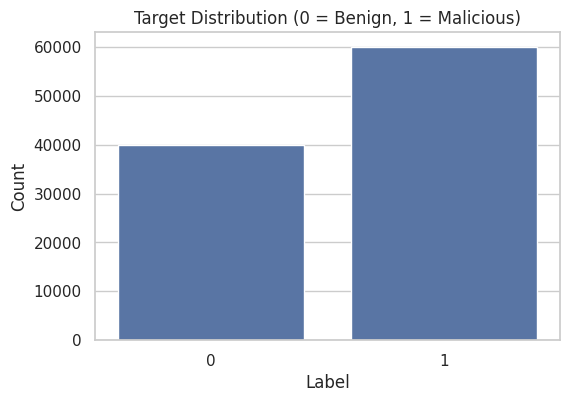

label
1    0.6
0    0.4
Name: proportion, dtype: float64

Insight: Check for significant class imbalance. If one class is <10%, we may need to use SMOTE or class weights.


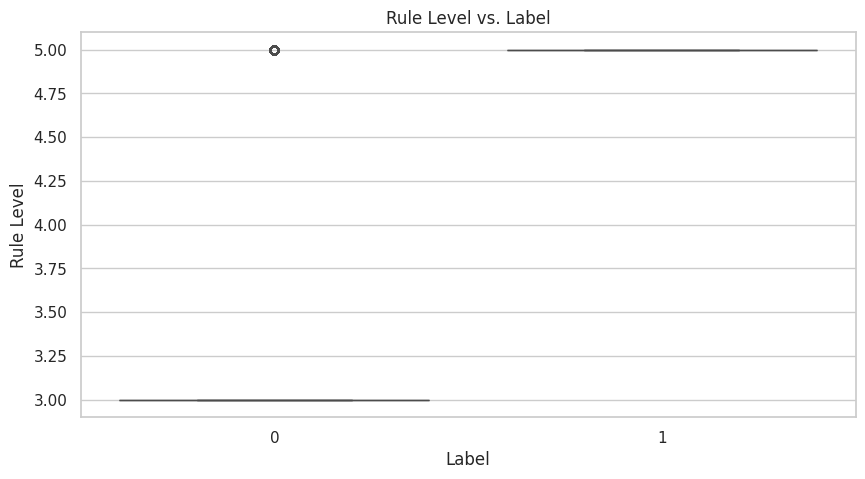


Insight: Malicious logs likely have a different 'rule_level' distribution (e.g., higher levels) than benign logs.


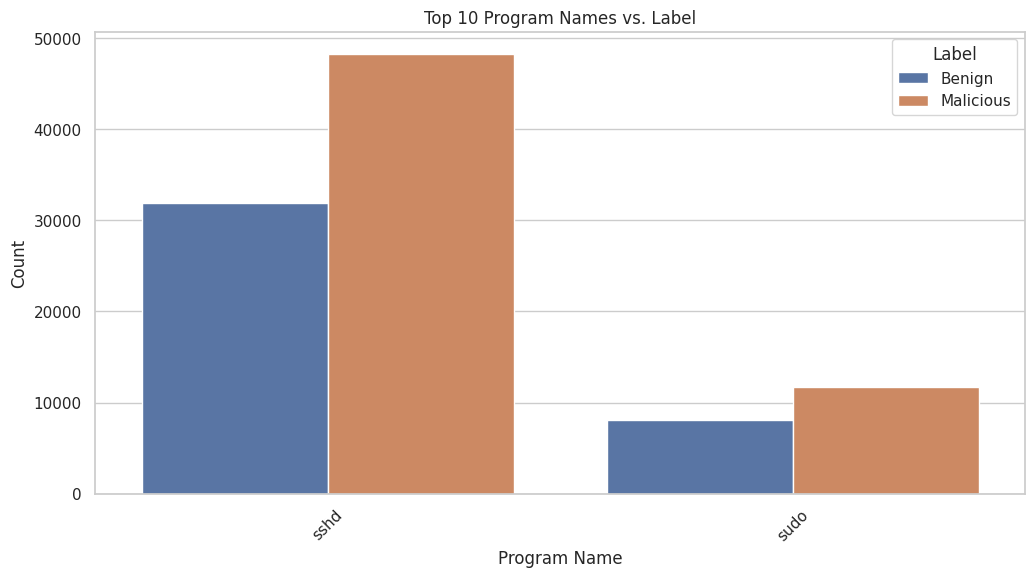


Insight: Certain programs (like 'sshd', 'sudo') will be highly correlated with specific events. This plot shows which programs generate the most malicious alerts.


In [ ]:
# Step 4: Exploratory Data Analysis (EDA)

# Set the theme for plots
sns.set_theme(style="whitegrid")

# Plot 1: Target Variable Distribution (Class Balance)
plt.figure(figsize=(6, 4))
sns.countplot(x=df_cleaned['label'])
plt.title('Target Distribution (0 = Benign, 1 = Malicious)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

print(df_cleaned['label'].value_counts(normalize=True))
print("\nInsight: Check for significant class imbalance. If one class is <10%, we may need to use SMOTE or class weights.")

# Plot 2: Rule Level vs. Malicious
plt.figure(figsize=(10, 5))
sns.boxplot(x='label', y='rule_level', data=df_cleaned)
plt.title('Rule Level vs. Label')
plt.xlabel('Label')
plt.ylabel('Rule Level')
plt.show()

print("\nInsight: Malicious logs likely have a different 'rule_level' distribution (e.g., higher levels) than benign logs.")

# Plot 3: Top 10 Program Names by Malicious Count
plt.figure(figsize=(12, 6))
# Get top 10 most frequent programs
top_programs = X['program_name'].value_counts().index[:10]
sns.countplot(data=df_cleaned[df_cleaned['program_name'].isin(top_programs)], x='program_name', hue='label', order=top_programs)
plt.title('Top 10 Program Names vs. Label')
plt.xlabel('Program Name')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Label', loc='upper right', labels=['Benign', 'Malicious'])
plt.show()

print("\nInsight: Certain programs (like 'sshd', 'sudo') will be highly correlated with specific events. This plot shows which programs generate the most malicious alerts.")

In [ ]:
# Step 5: Feature Engineering & Selection

# Import necessary classes just for this cell
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# 1. Define Categorical and Numerical Features
# This is our "Feature Selection" step. We are selecting all remaining columns.
# We must make sure 'srcuser' is in the list ONLY if it was NOT dropped in Step 3.

numerical_features = ['rule_level', 'hour_of_day', 'day_of_week']
categorical_features = ['agent_name', 'decoder_name', 'program_name', 'rule_groups']

if 'srcuser' in X.columns:
    categorical_features.append('srcuser')

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# 2. Create the Preprocessing Pipeline
# This is our main "Feature Engineering" step for the model.
# - Numerical features will be scaled.
# - Categorical features will be One-Hot Encoded.

# Create transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Create the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough' # In case we missed any columns
)

print("\nPreprocessing pipeline created successfully.")
print("This pipeline will scale numerical data and one-hot encode categorical data.")

Numerical features: ['rule_level', 'hour_of_day', 'day_of_week']
Categorical features: ['agent_name', 'decoder_name', 'program_name', 'rule_groups', 'srcuser']

Preprocessing pipeline created successfully.
This pipeline will scale numerical data and one-hot encode categorical data.


In [ ]:
# Step 6: Split Data (Train, Validation, & Test Sets)

# We will use a 3-way split:
# 1. Training Set (64%): To train the model.
# 2. Validation Set (16%): To tune hyperparameters and for early stopping.
# 3. Test Set (20%): To give a final, unbiased evaluation.

# First, split into Train_Full (80%) and Test (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second, split Train_Full (80%) into Train (64%) and Validation (16%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

print("--- Data Splitting Complete ---")
print(f"Total samples: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

--- Data Splitting Complete ---
Total samples: 100000
Training samples: 64000
Validation samples: 16000
Test samples: 20000


In [ ]:
# Step 7: Model Selection

# As discussed with mentors, our goal is a high-performance model
# that can also be updated efficiently.

# Model: LightGBM (LGBMClassifier)

# --- Justification ---
# 1. Performance: LightGBM (a Gradient Boosting model) is a state-of-the-art
#    algorithm that is well-known for its high accuracy, speed, and
#    efficiency, especially on large datasets.
#
# 2. Solves Key Mentor Feedback:
#    - 'Time Computation': It's much faster than other boosting models.
#    - 'Incremental Learning': It natively supports incremental training
#      (using the 'init_model' parameter). This is critical for our
#      24-hour retraining pipeline and solves the problem of "retraining
#      from scratch" that a 'Bagging' model like RandomForest would have.
#
# 3. Explainability: We can extract feature importances to see *why*
#    the model is making its decisions, which is vital for our analysts.

print("Model Selected: LightGBM (LGBMClassifier)")

Model Selected: LightGBM (LGBMClassifier)


In [ ]:
# Step 8: Model Training (Baseline)

# Import the necessary model and callbacks for this cell
from lightgbm import LGBMClassifier
import lightgbm as lgb

# First, we must apply the preprocessor to our data
# We fit on the training data, and transform all sets

print("Applying preprocessing pipeline...")
# Note: Ensure the 'preprocessor' object from Step 5 is in memory!
# If not, re-run Step 5.
try:
    preprocessor
except NameError:
    print("ERROR: 'preprocessor' not found. Please re-run Step 5.")
    # This is a placeholder to stop the cell
    raise

preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_val_processed = preprocessor.transform(X_val)
X_test_processed = preprocessor.transform(X_test)

print("Data processing complete.")

# Create a baseline LGBM model
# We use the validation set for early stopping.
# This stops the model from training if its performance
# on the validation set doesn't improve for 20 rounds.
print("\nTraining baseline LightGBM model with early stopping...")

baseline_model = LGBMClassifier(
    random_state=42,
    n_estimators=1000, # High number, will be cut off by early stopping
    n_jobs=-1
)

baseline_model.fit(
    X_train_processed,
    y_train,
    eval_set=[(X_val_processed, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.log_evaluation(period=100), lgb.early_stopping(stopping_rounds=20)]
)

print("\n--- Baseline Model Training Complete ---")

Applying preprocessing pipeline...
Data processing complete.

Training baseline LightGBM model with early stopping...
[LightGBM] [Info] Number of positive: 38400, number of negative: 25600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.041668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465
Training until validation scores don't improve for 20 rounds
[100]	valid_0's binary_logloss: 0.0408981
[200]	valid_0's binary_logloss: 0.0356539
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.0355754

--- Baseline Model Training Complete ---


In [ ]:
# Step 9: Hyperparameter Tuning

print("Starting Hyperparameter Tuning with RandomizedSearchCV...")
print("This may take a few minutes...")

# Define the parameter grid to search
# These are the most important parameters for LGBM
param_dist = {
    'n_estimators': [100, 200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [20, 31, 40, 50],
    'max_depth': [-1, 10, 20],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
}

# Create the RandomizedSearchCV object
# n_iter=25 means it will try 25 random combinations
# cv=3 means it will use 3-fold cross-validation
# scoring='f1' means it will try to optimize for the F1-score
random_search = RandomizedSearchCV(
    estimator=LGBMClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=25,
    scoring='f1',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit on the processed training data
random_search.fit(X_train_processed, y_train)

print("\n--- Tuning Complete ---")
print(f"Best F1 Score from search: {random_search.best_score_:.4f}")
print("Best Hyperparameters found:")
print(random_search.best_params_)

# Get the best model from the search
best_model = random_search.best_estimator_

Starting Hyperparameter Tuning with RandomizedSearchCV...
This may take a few minutes...
Fitting 3 folds for each of 25 candidates, totalling 75 fits
[LightGBM] [Info] Number of positive: 38400, number of negative: 25600
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 106
[LightGBM] [Info] Number of data points in the train set: 64000, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600000 -> initscore=0.405465
[LightGBM] [Info] Start training from score 0.405465

--- Tuning Complete ---
Best F1 Score from search: 0.9907
Best Hyperparameters found:
{'subsample': 1.0, 'num_leaves': 40, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


--- Evaluating Best Tuned Model on Final Test Set ---


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



--- Key Performance Metrics ---
  Accuracy: 0.9881
 Precision: 0.9823  (How many predicted positives were correct)
    Recall: 0.9982  (How many actual positives were found)
  F1-Score: 0.9902  (Harmonic mean of Precision and Recall)
  Log Loss: 0.0396  (Model's confidence error, lower is better)

--- Classification Report ---
               precision    recall  f1-score   support

   Benign (0)       1.00      0.97      0.99      8000
Malicious (1)       0.98      1.00      0.99     12000

     accuracy                           0.99     20000
    macro avg       0.99      0.99      0.99     20000
 weighted avg       0.99      0.99      0.99     20000



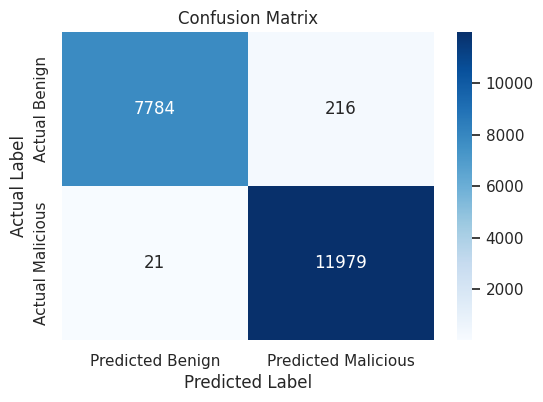

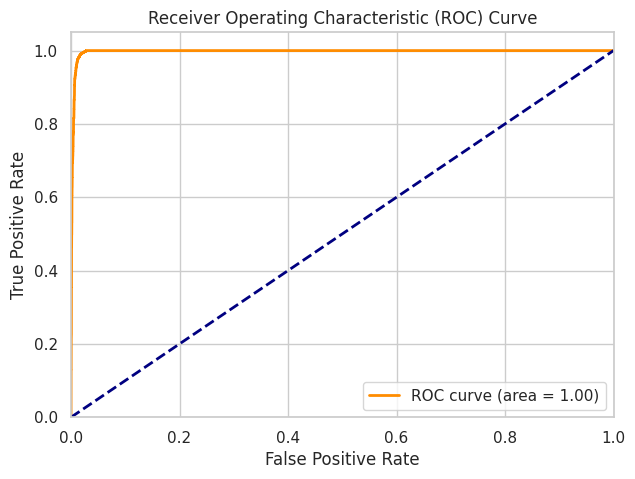

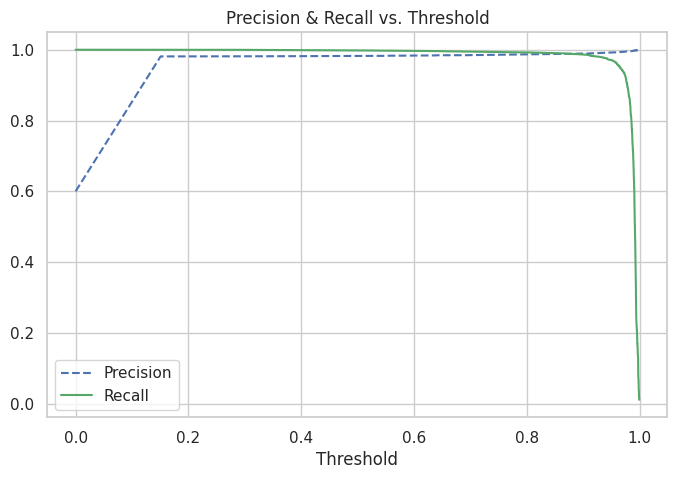


Insight: The plot above shows the trade-off. The default threshold is 0.5.
If you need 99% precision, you can find the threshold that gives you that,
even if it means lower recall. This is crucial for your analyst feedback loop.


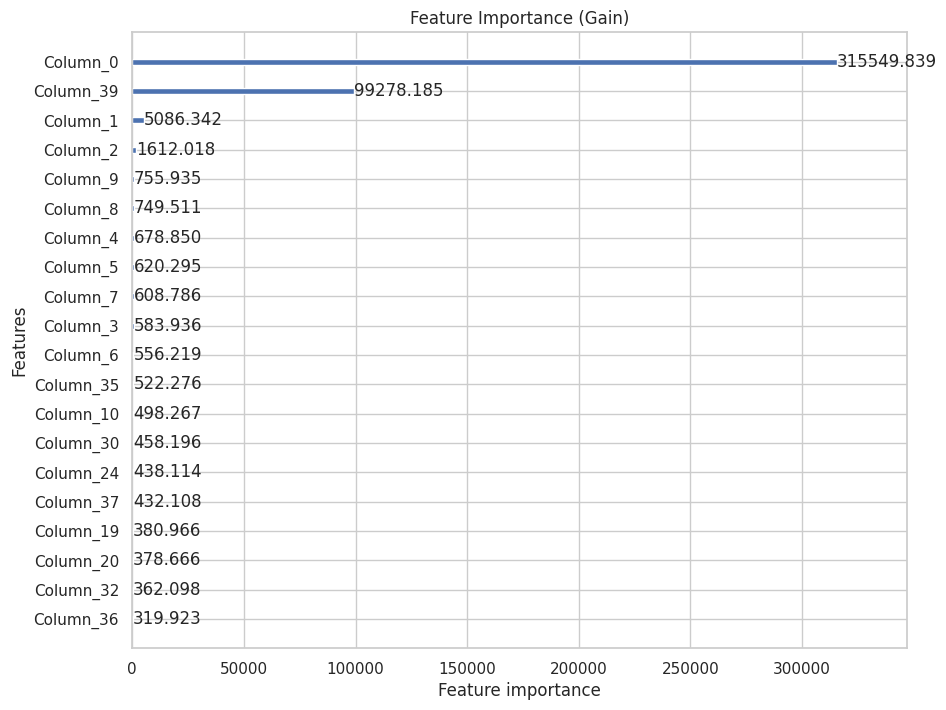


Insight: The Feature Importance plot shows which features the model
used most to make its decisions (e.g., 'rule_level' or a specific 'program_name').


In [ ]:
# Step 10: Model Evaluation (On Held-Out Test Set)

# Import all necessary evaluation metrics for this cell
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    log_loss,
    roc_curve,
    auc,  # <-- THIS IS THE MISSING IMPORT
    precision_recall_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# Ensure 'best_model' is in memory
try:
    best_model
except NameError:
    print("ERROR: 'best_model' not found. Please re-run Step 9.")
    raise

# Ensure 'X_test_processed' and 'y_test' are in memory
try:
    X_test_processed
    y_test
except NameError:
    print("ERROR: 'X_test_processed' or 'y_test' not found. Please re-run Step 8.")
    raise

print("--- Evaluating Best Tuned Model on Final Test Set ---")

# 1. Get Predictions
y_pred = best_model.predict(X_test_processed)
y_proba = best_model.predict_proba(X_test_processed)[:, 1] # Probability of 'malicious'

# 2. Calculate Key Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
loss = log_loss(y_test, y_proba)

print("\n--- Key Performance Metrics ---")
print(f"  Accuracy: {accuracy:.4f}")
print(f" Precision: {precision:.4f}  (How many predicted positives were correct)")
print(f"    Recall: {recall:.4f}  (How many actual positives were found)")
print(f"  F1-Score: {f1:.4f}  (Harmonic mean of Precision and Recall)")
print(f"  Log Loss: {loss:.4f}  (Model's confidence error, lower is better)")

# 3. Classification Report
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Benign (0)', 'Malicious (1)']))

# 4. Confusion Matrix Plot
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Benign', 'Predicted Malicious'],
            yticklabels=['Actual Benign', 'Actual Malicious'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# 5. ROC Curve Plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# 6. Precision-Recall vs. Threshold Plot (Answers "Threshold Value" question)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_proba)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision & Recall vs. Threshold")
plt.grid(True)
plt.show()
print("\nInsight: The plot above shows the trade-off. The default threshold is 0.5.")
print("If you need 99% precision, you can find the threshold that gives you that,")
print("even if it means lower recall. This is crucial for your analyst feedback loop.")

# 7. Feature Importance Plot
# Get feature names from the preprocessor
# Ensure 'preprocessor' is in memory
try:
    preprocessor
except NameError:
    print("ERROR: 'preprocessor' not found. Please re-run Step 5.")
    raise

# Ensure 'categorical_features' is in memory
try:
    categorical_features
except NameError:
    print("ERROR: 'categorical_features' not found. Please re-run Step 5.")
    raise

cat_features = list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
all_features = numerical_features + cat_features

# Plot feature importance
lgb.plot_importance(best_model, max_num_features=20, figsize=(10, 8),
                    importance_type='gain', title='Feature Importance (Gain)')
plt.show()

print("\nInsight: The Feature Importance plot shows which features the model")
print("used most to make its decisions (e.g., 'rule_level' or a specific 'program_name').")

In [ ]:
# ===== STEP 11: EXPORT COMPLETE PIPELINE FOR PRODUCTION =====

import joblib
from sklearn.pipeline import Pipeline
import os

print("=" * 60)
print("EXPORTING FULL PIPELINE FOR PRODUCTION")
print("=" * 60)

# The issue: best_model is JUST the LGBMClassifier
# We need to combine it with the preprocessor!

# Create the COMPLETE pipeline
full_production_pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Step 5: StandardScaler + OneHotEncoder
    ('classifier', best_model)        # Step 9: Tuned LGBMClassifier
])

print("\n✓ Full pipeline created")
print(f"  Steps: {list(full_production_pipeline.named_steps.keys())}")

# Verify it works on raw data (NOT preprocessed!)
print("\n🧪 Testing pipeline on RAW data...")
test_raw = X_test.iloc[[0]]  # Raw data with categorical strings
test_pred = full_production_pipeline.predict_proba(test_raw)
print(f"✓ Test prediction successful: {test_pred[0][1]:.3f}")

# Save to backend/models/current.joblib
# os.makedirs('../backend/models', exist_ok=True)
output_path = './current.joblib'

joblib.dump(full_production_pipeline, output_path)

print(f"\n{'='*60}")
print("✓✓✓ SUCCESS! FULL PIPELINE EXPORTED!")
print(f"{'='*60}")
print(f"\n📁 Saved to: {output_path}")
print(f"📦 File size: {os.path.getsize(output_path) / 1024:.1f} KB")
print(f"\n📋 Pipeline contains:")
print(f"   1. preprocessor (StandardScaler + OneHotEncoder)")
print(f"   2. classifier (LGBMClassifier with tuned params)")
print(f"\n🚀 Now restart your backend:")
print(f"   cd backend")
print(f"   uvicorn app:app --reload")
print(f"\n✅ Predictions will now work with categorical features!")